In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
import math
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Science

### Import datasets

In [2]:
df_restaurants = pd.read_csv("Datasets/Capstone 3/restaurants.csv")
df_restaurants.head()

,id,name
0,1,Bob's Diner
1,2,Beachfront Bar
2,3,Sweet Shack
3,4,Fou Cher
4,5,Corner Cafe


In [3]:
df_items = pd.read_csv("Datasets/Capstone 3/items.csv")
df_items.head()

,id,store_id,name,kcal,cost
0,1,4,Chocolate Cake,554,6.71
1,2,4,Breaded Fish with Vegetables Meal,772,15.09
2,3,1,Sweet Fruity Cake,931,29.22
3,4,1,Amazing Steak Dinner with Rolls,763,26.42
4,5,5,Milk Cake,583,6.07


In [4]:
df_sales = pd.read_csv("Datasets/Capstone 3/sales.csv")
df_sales.head()

,date,item_id,price,item_count
0,2019-01-01,3,29.22,2.0
1,2019-01-01,4,26.42,22.0
2,2019-01-01,12,4.87,7.0
3,2019-01-01,13,4.18,12.0
4,2019-01-01,16,3.21,136.0


In [5]:
def get_outliers(df, col):
    z_col = zscore(df[col])
    threshold = 2
    outlier = np.where(z_col - threshold > 0, True, np.where(z_col + threshold < 0, True, False))
    return df[outlier == True].index.tolist()

def remove_outliers(df, cols):
    outliers = []
    for col in cols:
        outliers.extend(get_outliers(df, col))
    return df.drop(index=outliers, axis=0)

In [6]:
df_items2 = remove_outliers(df_items, ["kcal", "cost"])
df_sales["date"] = pd.to_datetime(df_sales["date"])
df_sales["date_int"] = df_sales["date"].dt.strftime('%Y%m%d').astype(int)
df_sales2 = remove_outliers(df_sales, ["date_int", "price", "item_count"])

In [7]:
# def factorize(df, cols):
#     for col in cols:
#         codes, _ = pd.factorize(df[col])
#         df[f"{col}_F"] = codes

In [8]:
# factorize(df_items2, ["name"])
# factorize(df_restaurants, ["name"])

### Merge data to create a single dataset

In [9]:
df_all = pd.merge(df_sales2, df_items2, left_on="item_id", right_on="id", left_index=False, right_index=False)
df_all.drop(columns=["id"], inplace=True)
df_all.rename(columns={"name": "item_name"}, inplace=True)
df_all = pd.merge(df_all, df_restaurants, left_on="store_id", right_on="id", left_index=False, right_index=False)
df_all.drop(columns=["id"], inplace=True)
df_all.rename(columns={"name": "store_name"}, inplace=True)
df_all = df_all[["date", "date_int", "item_id", "price", "item_count", "item_name","kcal", "store_id", "store_name"]]
df_all = df_all[df_all["item_count"] > 0.0]
df_all

,date,date_int,item_id,price,item_count,item_name,kcal,store_id,store_name
0,2019-01-01,20190101,3,29.22,2.0,Sweet Fruity Cake,931,1,Bob's Diner
1,2019-01-01,20190101,4,26.42,22.0,Amazing Steak Dinner with Rolls,763,1,Bob's Diner
2,2019-01-01,20190101,12,4.87,7.0,Fantastic Sweet Cola,478,1,Bob's Diner
3,2019-01-01,20190101,13,4.18,12.0,Sweet Frozen Soft Drink,490,1,Bob's Diner
4,2019-01-01,20190101,21,23.23,13.0,Amazing Fish with Vegetables Meal,269,1,Bob's Diner
...,...,...,...,...,...,...,...,...,...
102354,2021-12-31,20211231,59,23.37,54.0,Blue Ribbon Beef Entree,392,1,Bob's Diner
102355,2021-12-31,20211231,67,7.00,6.0,Sweet Lamb Cake,558,1,Bob's Diner
102356,2021-12-31,20211231,68,8.70,1.0,Blue Ribbon Fruity Milky Cake,652,1,Bob's Diner
102357,2021-12-31,20211231,73,5.16,10.0,Milky Cake,596,1,Bob's Diner


### Distribution of Item Sales

Distribution of Features


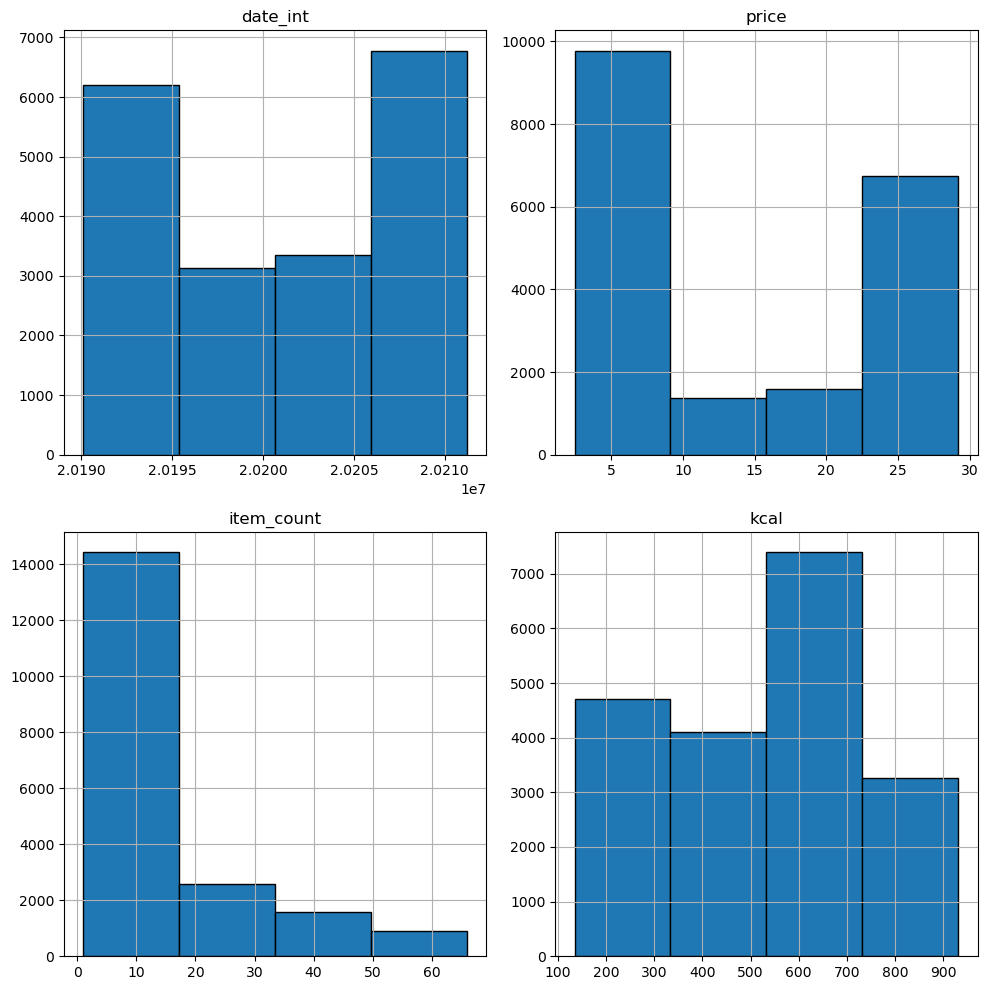

In [10]:
df_features = df_all[["date_int", "price", "item_count", "kcal"]]
df_features.hist(bins=4, figsize=(10, 10), edgecolor='black')
plt.tight_layout()
print("Distribution of Features")
plt.show()

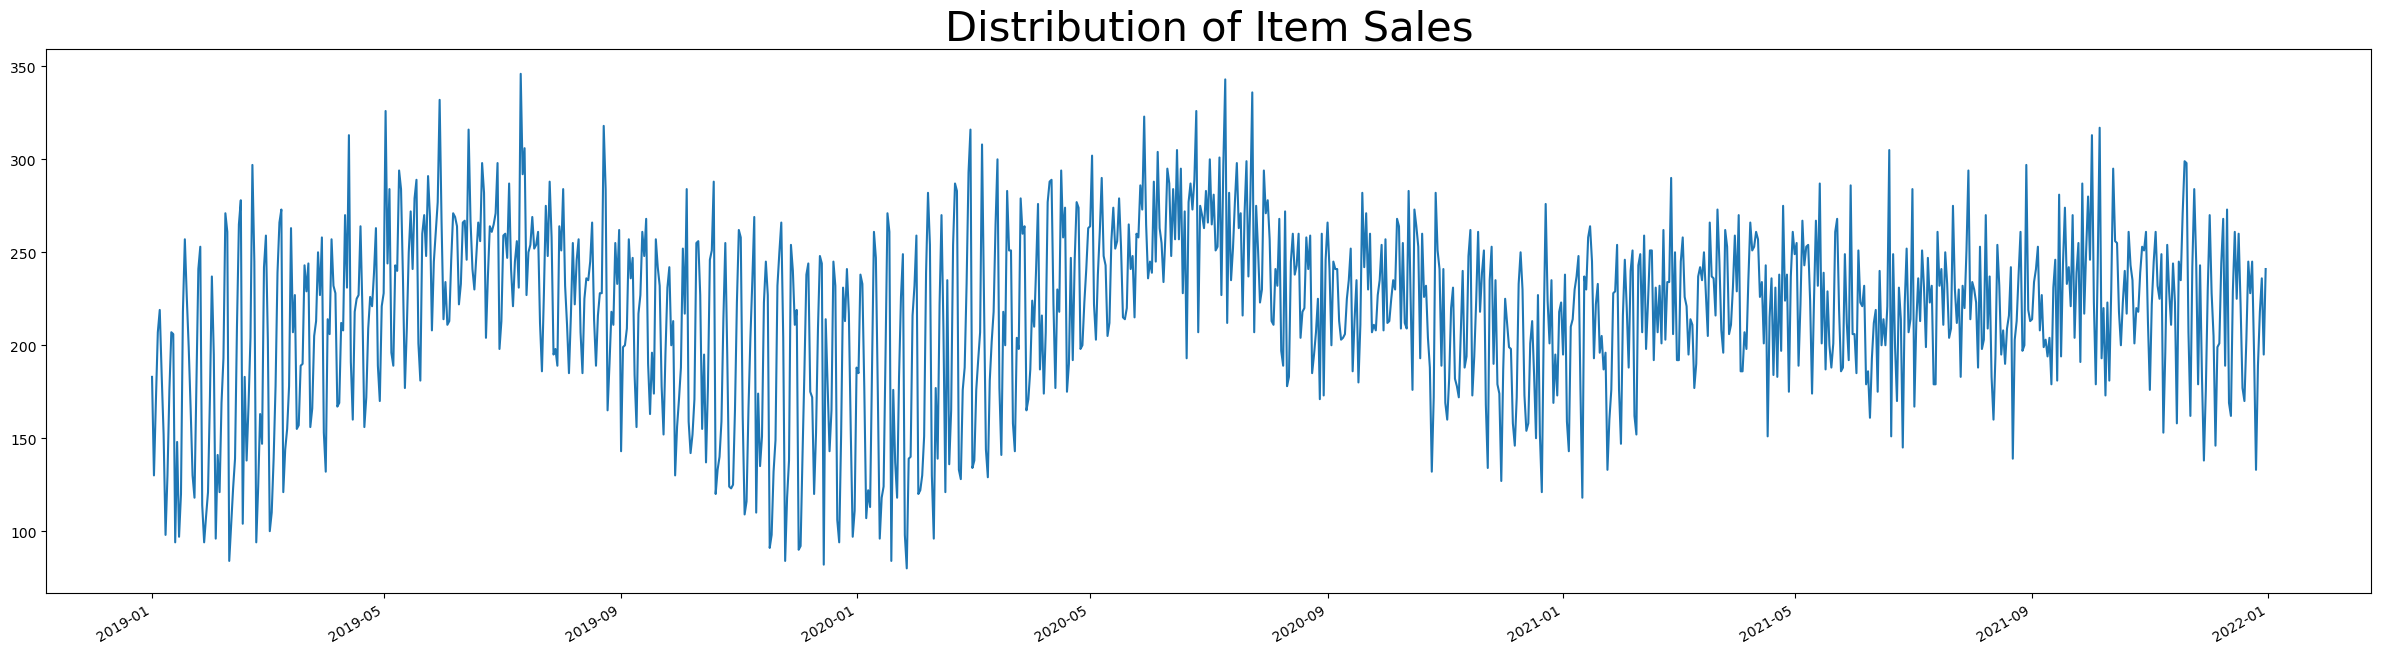

In [11]:
df_item_sales = df_all[["date", "item_count"]].groupby(by=["date"]).sum().reset_index()
fig, ax = plt.subplots(figsize=(30, 8))
ax.plot(df_item_sales["date"], df_item_sales["item_count"])
ax.xaxis_date()
fig.autofmt_xdate()
ax.set_title("Distribution of Item Sales", size = 30)
plt.show()

In [12]:
df_item_sales

,date,item_count
0,2019-01-01,183.0
1,2019-01-02,130.0
2,2019-01-03,170.0
3,2019-01-04,207.0
4,2019-01-05,219.0
...,...,...
1091,2021-12-27,189.0
1092,2021-12-28,218.0
1093,2021-12-29,236.0
1094,2021-12-30,195.0


Text(0.5, 1.0, 'Distribution of Item Sales by Day')

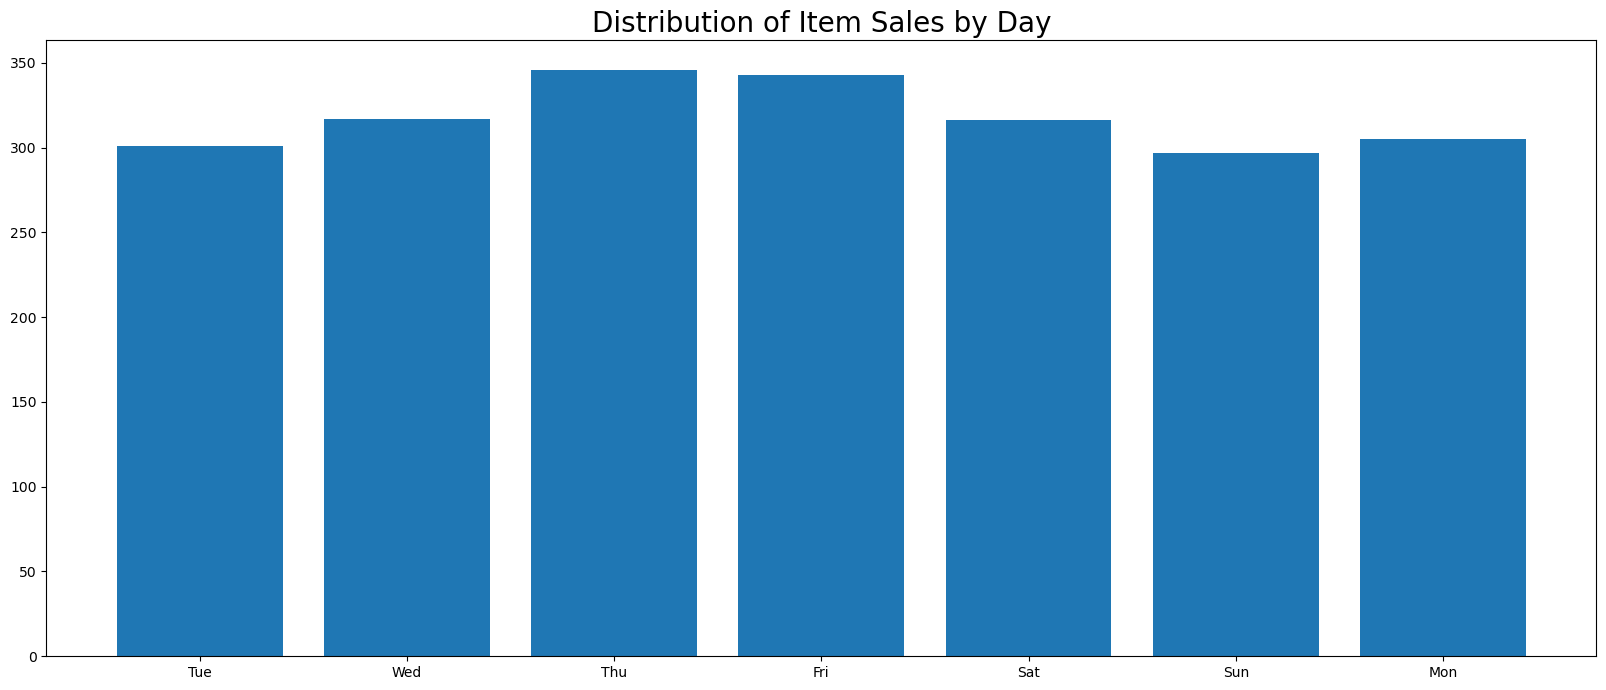

In [13]:
df_item_sales["day"] = df_item_sales["date"].dt.strftime("%a")
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(df_item_sales["day"], df_item_sales["item_count"])
ax.set_title("Distribution of Item Sales by Day", size = 20)

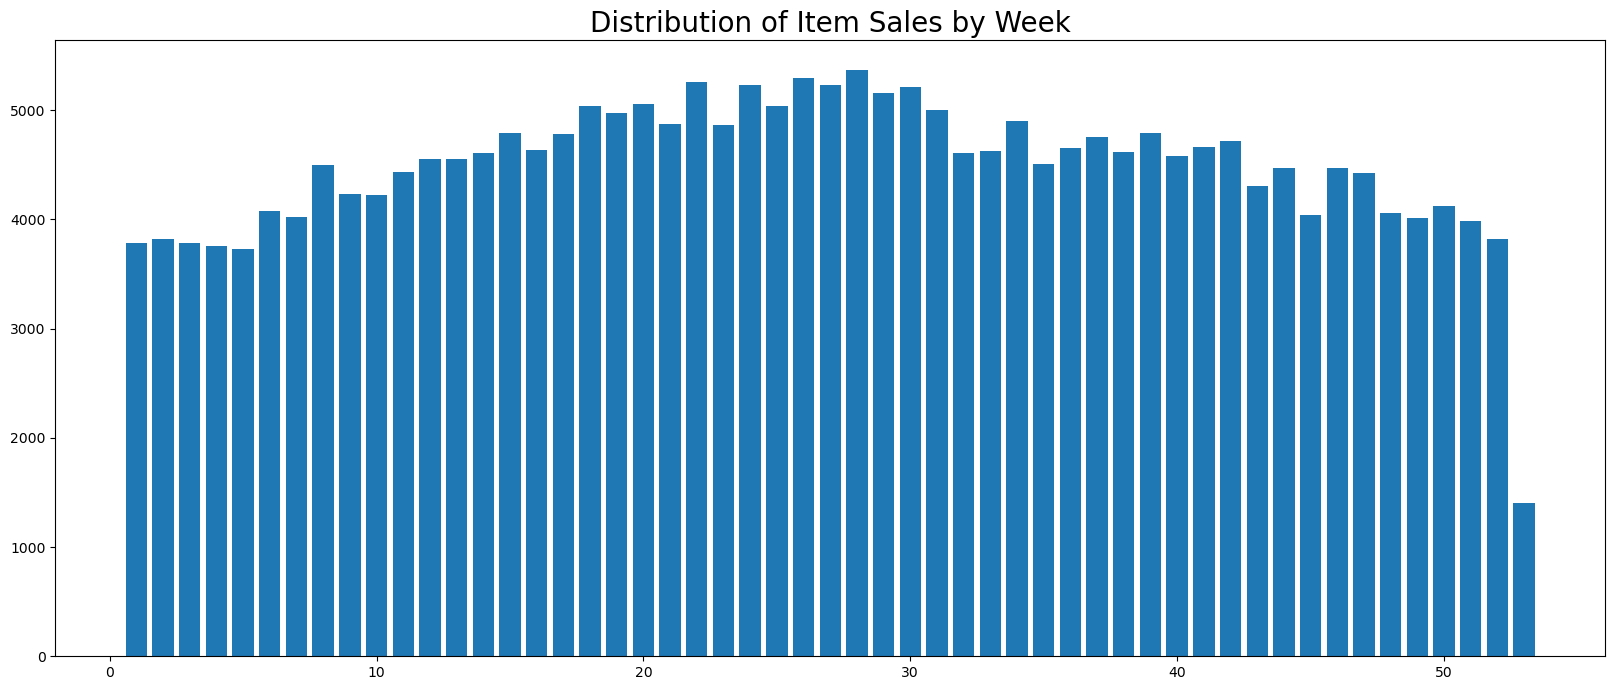

In [14]:
df_item_sales["week"] = df_item_sales["date"].dt.isocalendar().week
df_item_sales_by_week = df_item_sales[["week", "item_count"]].groupby(by=["week"]).sum().reset_index()
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(df_item_sales_by_week["week"], df_item_sales_by_week["item_count"])
ax.set_title("Distribution of Item Sales by Week", size = 20)
plt.show()

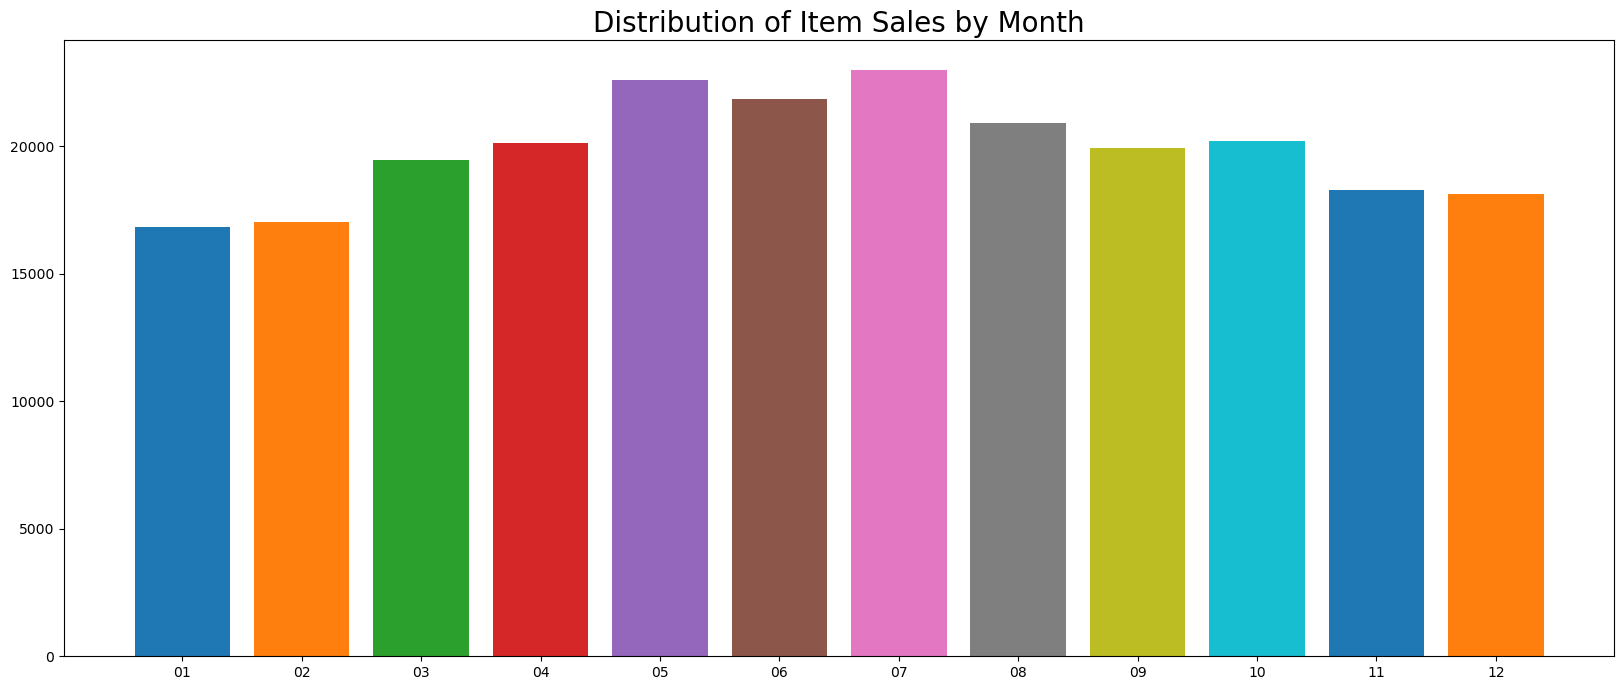

In [15]:
df_item_sales["month"] = df_item_sales["date"].dt.strftime("%m")
df_item_sales_by_month = df_item_sales[["month", "item_count"]].groupby(by=["month"]).sum().reset_index()
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(df_item_sales_by_month["month"], df_item_sales_by_month["item_count"], color = sns.color_palette())
ax.set_title("Distribution of Item Sales by Month", size = 20)
plt.show()

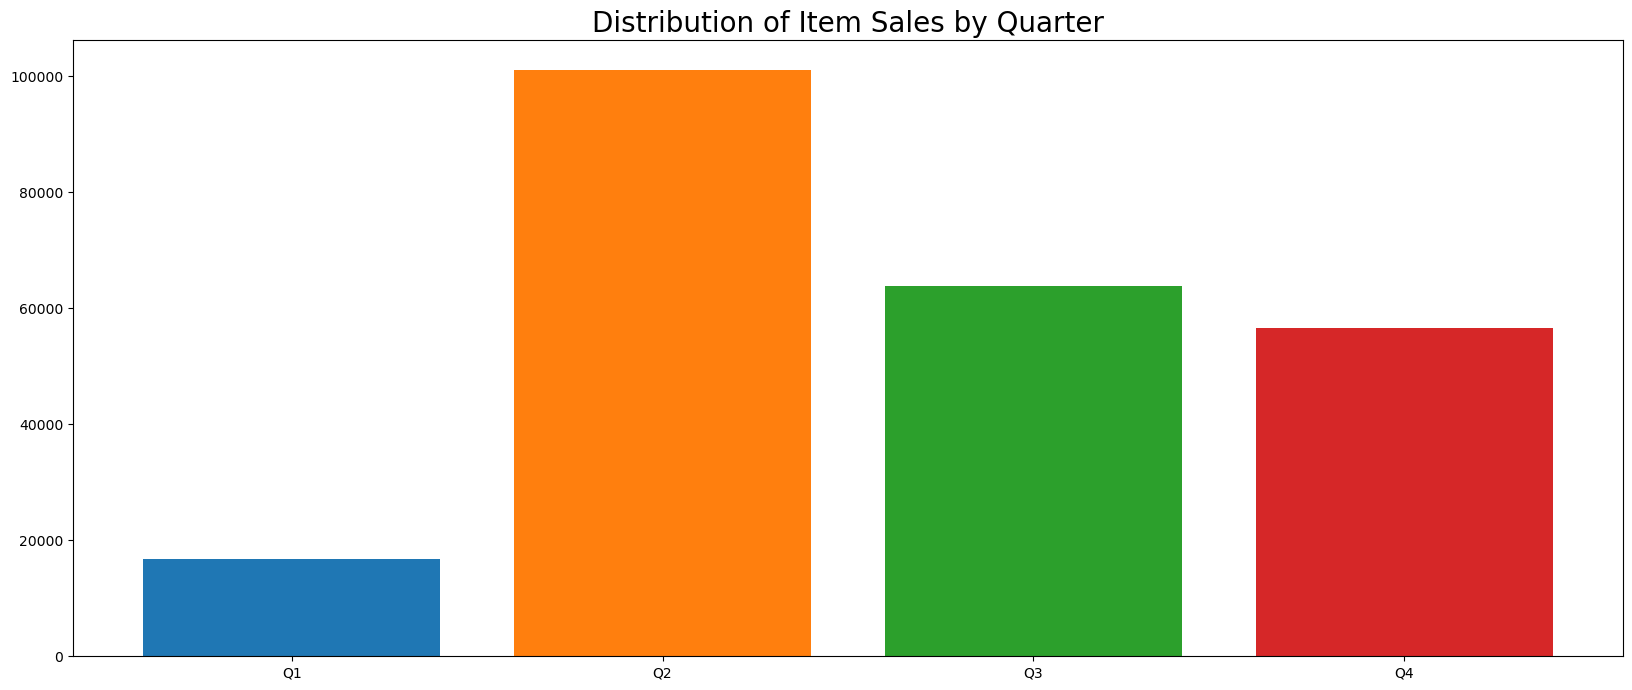

In [16]:
df_item_sales["quarter"] = (df_item_sales["month"].astype(int) / 4 + 1).round().map('Q{:,.0f}'.format)
df_item_sales_by_quarter = df_item_sales[["quarter", "item_count"]].groupby(by=["quarter"]).sum().reset_index()
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(df_item_sales_by_quarter["quarter"], df_item_sales_by_quarter["item_count"], color = sns.color_palette())
ax.set_title("Distribution of Item Sales by Quarter", size = 20)
plt.show()

### Distribution of Store Sales

In [17]:
df_store_sales = df_all[["store_name", "date", "item_count"]].groupby(by=["store_name", "date"]).sum().reset_index()
df_store_sales["year"] = df_store_sales["date"].dt.strftime("%Y")
df_store_sales["month"] = df_store_sales["date"].dt.strftime("%m")
df_store_sales["day"] = df_store_sales["date"].dt.strftime("%a")
df_store_sales_by_year = df_store_sales[["store_name", "year", "item_count"]].groupby(by=["store_name", "year"]).sum().reset_index()
df_store_sales_by_month = df_store_sales[["store_name", "month", "item_count"]].groupby(by=["store_name", "month"]).sum().reset_index()
df_store_sales_by_day = df_store_sales[["store_name", "day", "item_count"]].groupby(by=["store_name", "day"]).sum().reset_index()

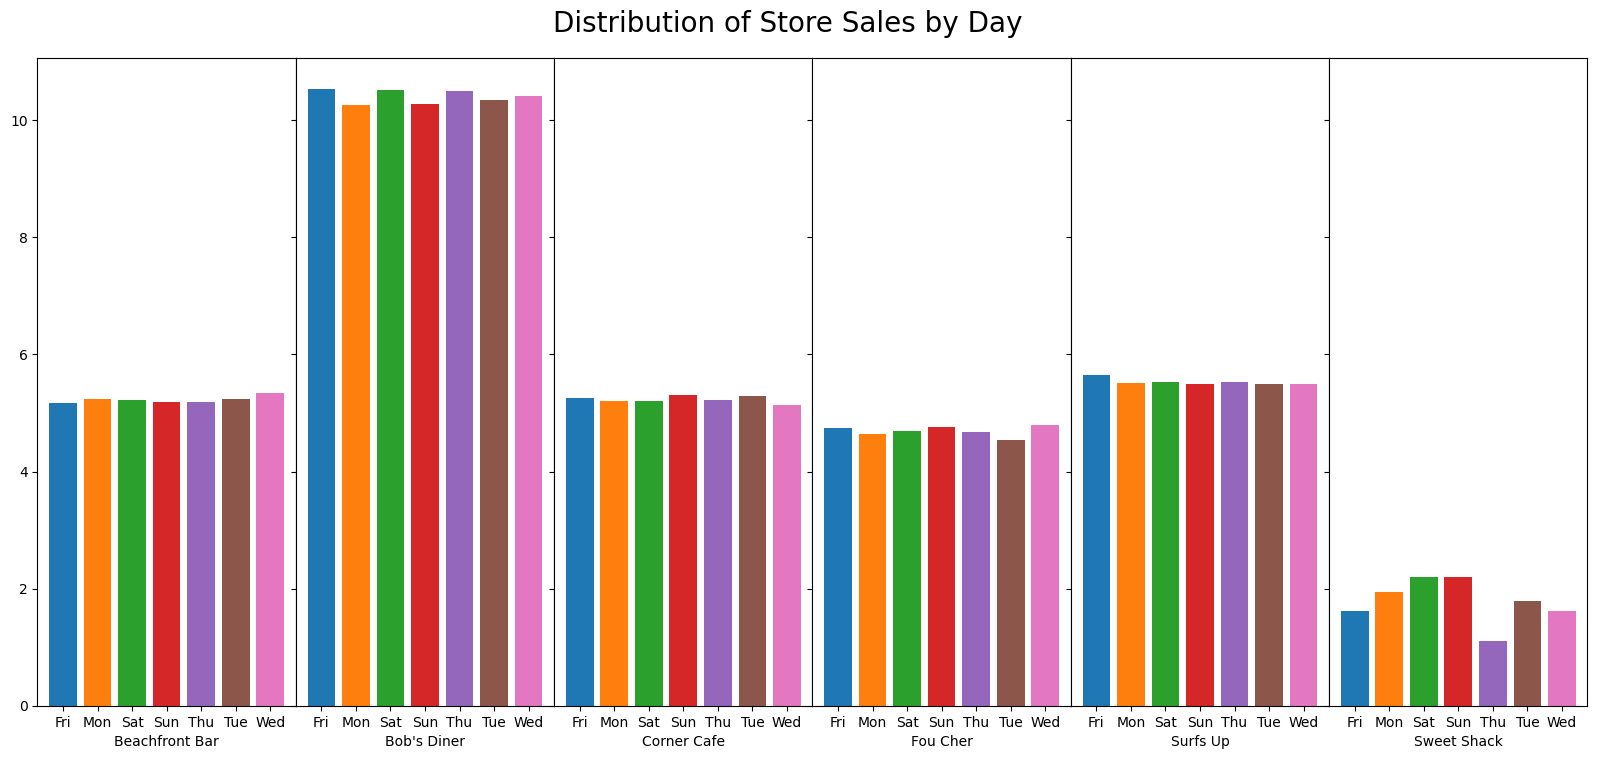

In [18]:
store_names = df_store_sales_by_day["store_name"].unique()
fig, axs = plt.subplots(1, len(store_names), sharey=True, figsize=(20,8))
for ax, store_name in zip(axs, store_names):
    df = df_store_sales_by_day[df_store_sales_by_day["store_name"] == store_name]
    ax.bar(df["day"], df["item_count"].map(math.log), color = sns.color_palette())
    ax.set_xlabel(store_name)
fig.suptitle("Distribution of Store Sales by Day", size=20)
fig.subplots_adjust(wspace=0, top=0.92)
plt.show()

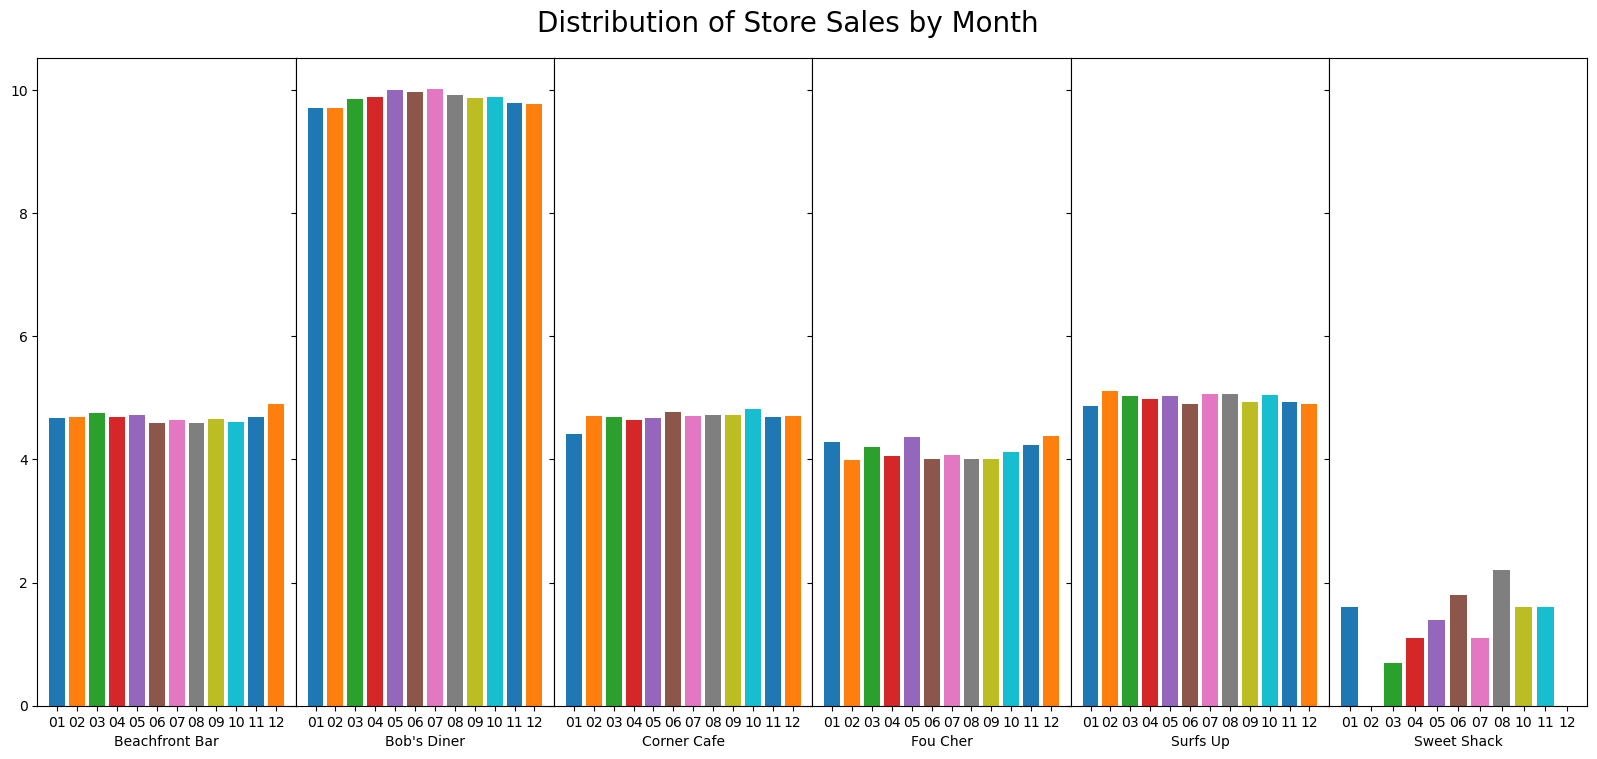

In [19]:
store_names = df_store_sales_by_month["store_name"].unique()
fig, axs = plt.subplots(1, len(store_names), sharey=True, figsize=(20,8))
for ax, store_name in zip(axs, store_names):
    df = df_store_sales_by_month[df_store_sales_by_month["store_name"] == store_name]
    ax.bar(df["month"], df["item_count"].map(math.log), color = sns.color_palette())
    ax.set_xlabel(store_name)
fig.suptitle("Distribution of Store Sales by Month", size=20)
fig.subplots_adjust(wspace=0, top=0.92)
plt.show()

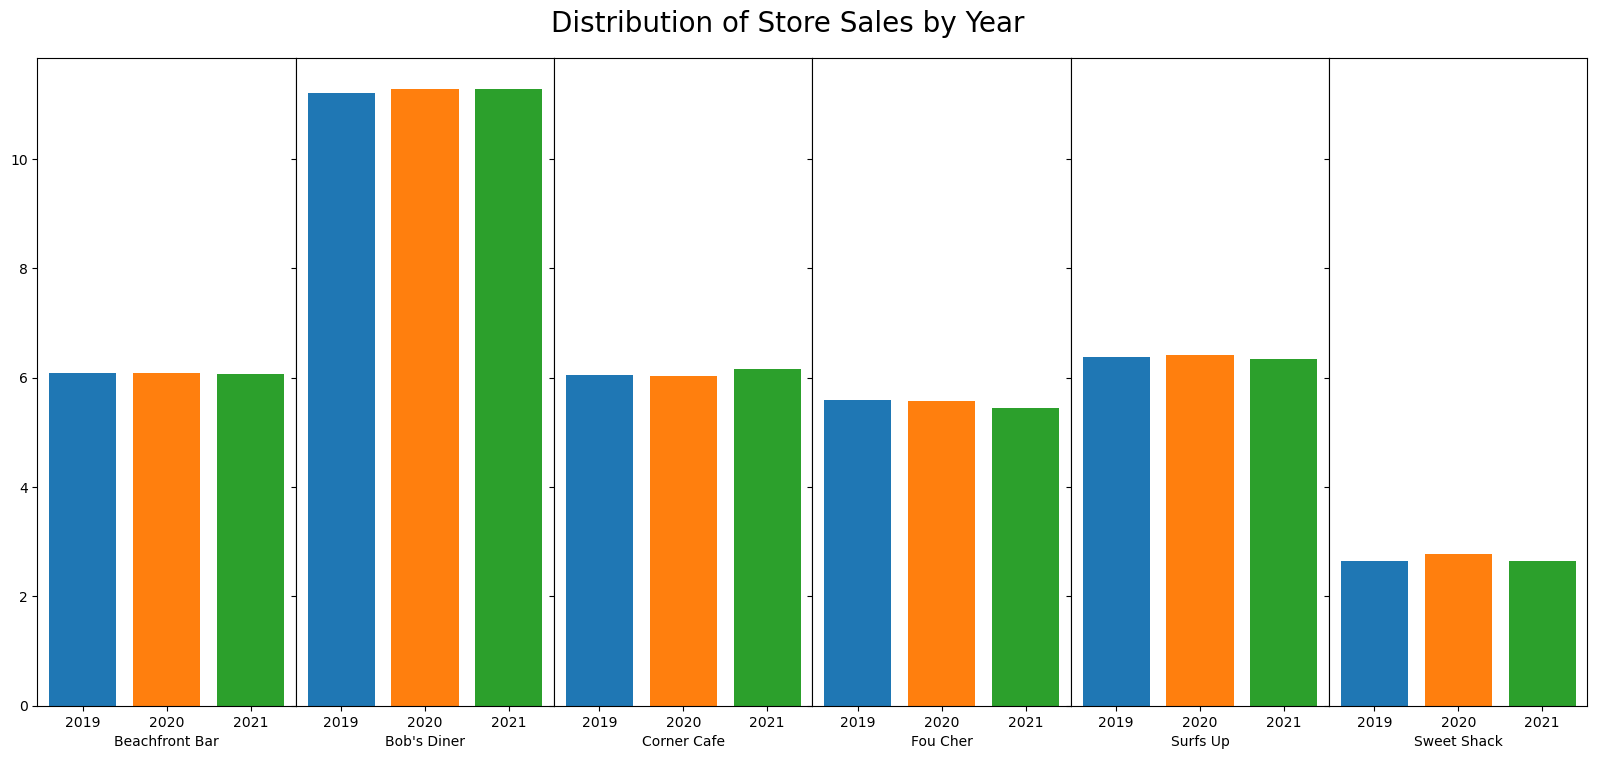

In [20]:
store_names = df_store_sales_by_year["store_name"].unique()
fig, axs = plt.subplots(1, len(store_names), sharey=True, figsize=(20,8))
for ax, store_name in zip(axs, store_names):
    df = df_store_sales_by_year[df_store_sales_by_year["store_name"] == store_name]
    ax.bar(df["year"], df["item_count"].map(math.log), color = sns.color_palette())
    ax.set_xlabel(store_name)
fig.suptitle("Distribution of Store Sales by Year", size = 20)
fig.subplots_adjust(wspace=0, top=0.92)
plt.show()

### 1. Which restaurant had the most sales? 

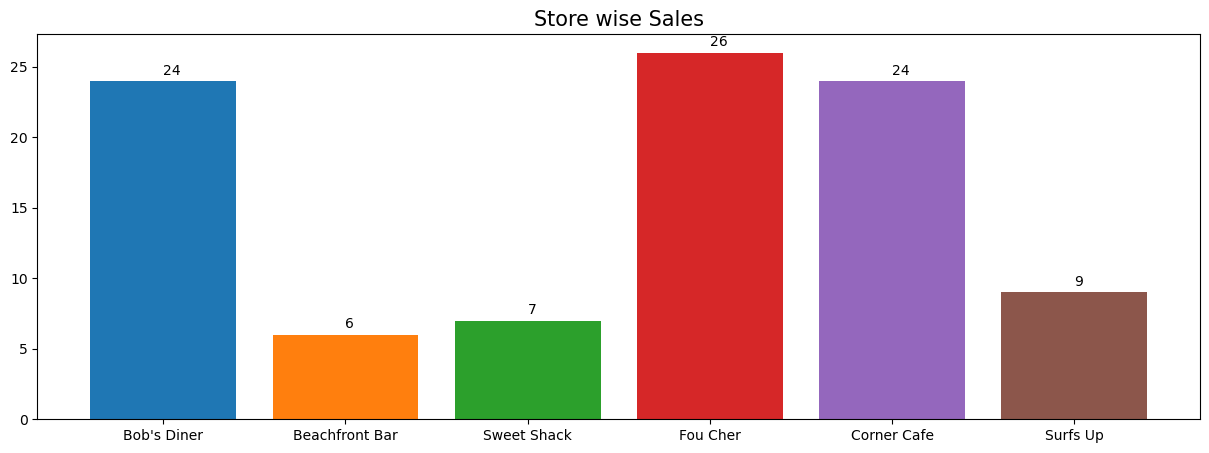

In [21]:
items_served = df_items2.groupby(['store_id']).agg({'id' : "nunique"}).squeeze()
plt.figure(figsize = (15,5))
plt.bar(items_served.index, items_served.values, color = sns.color_palette())
plt.xticks(range(1,7), df_restaurants.name)
for i in range(1,7):
  plt.annotate(items_served[i], xy = (i, items_served[i]+0.45), size = 10)
plt.title("Store wise Sales", size = 15)
plt.show()

### Fou Cher had the most sales.

### 2. Identify the most popular items overall and the stores where they are being sold. Also, find out the most popular item at each store

In [22]:
df_pop_sales = df_all[["store_name", "item_name", "item_count"]].groupby(by=["store_name", "item_name"]).sum().reset_index()
df_pop_sales

,store_name,item_name,item_count
0,Beachfront Bar,Awesome Vodka Cocktail,12.0
1,Beachfront Bar,Fantastic Milky Smoothy,1147.0
2,Beachfront Bar,Original Crazy Cocktail,106.0
3,Beachfront Bar,Original Gin Cocktail,21.0
4,Beachfront Bar,Sweet Vegi Soft Drink,19.0
...,...,...,...
83,Sweet Shack,Blue Ribbon Milky Cake,5.0
84,Sweet Shack,Fantastic Cake,14.0
85,Sweet Shack,Fantastic Milky Smoothy,18.0
86,Sweet Shack,Milky vegi Smoothy,6.0


In [23]:
df_popitem_sales = df_pop_sales[["item_name", "item_count"]].groupby(by=["item_name"]).sum().sort_values("item_count", ascending=False).reset_index()
df_popitem_sales

,item_name,item_count
0,Blue Ribbon Beef Entree,38034.0
1,Amazing Steak Dinner with Rolls,33940.0
2,Amazing pork lunch,32631.0
3,Sweet Frozen Soft Drink,26860.0
4,Sea Bass with Vegetables Dinner,23839.0
...,...,...
80,Amazing Sweet Breaded Carrot Cake,2.0
81,Chocolate Cake,1.0
82,Original Sweet Milky Soft Drink,1.0
83,Fruity Milky Cake,1.0


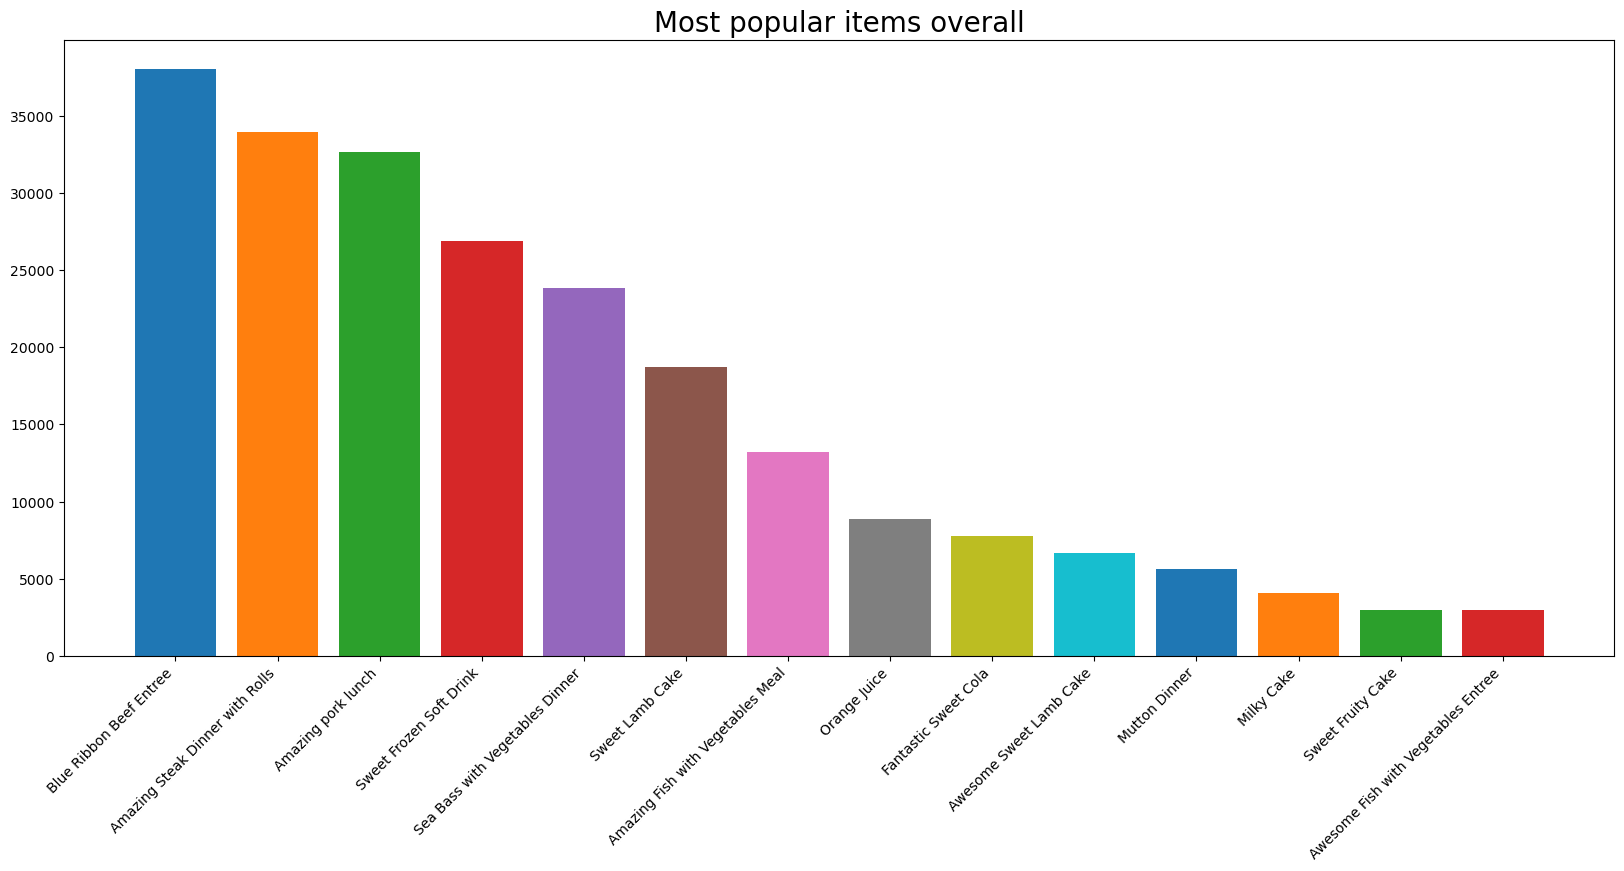

In [24]:
fig, ax = plt.subplots(figsize=(20, 8))
df = df_popitem_sales[df_popitem_sales["item_count"] > 2000]
ax.bar(df["item_name"], df["item_count"], color = sns.color_palette())
ax.set_title("Most popular items overall", size=20)
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df["item_name"], rotation=45, ha="right")
plt.show()

In [25]:
df_top10_items = df_popitem_sales[df_popitem_sales["item_count"] > 2000].iloc[:10,:]
df_top10_items

,item_name,item_count
0,Blue Ribbon Beef Entree,38034.0
1,Amazing Steak Dinner with Rolls,33940.0
2,Amazing pork lunch,32631.0
3,Sweet Frozen Soft Drink,26860.0
4,Sea Bass with Vegetables Dinner,23839.0
5,Sweet Lamb Cake,18696.0
6,Amazing Fish with Vegetables Meal,13190.0
7,Orange Juice,8835.0
8,Fantastic Sweet Cola,7791.0
9,Awesome Sweet Lamb Cake,6674.0


In [26]:
idx = df_pop_sales.groupby("store_name")["item_count"].idxmax()
df_popitem_store = df_pop_sales.loc[idx].reset_index(drop=True)
df_popitem_store

,store_name,item_name,item_count
0,Beachfront Bar,Fantastic Milky Smoothy,1147.0
1,Bob's Diner,Blue Ribbon Beef Entree,38034.0
2,Corner Cafe,Frozen Milky Smoothy,273.0
3,Fou Cher,Original Fruity Cod with Bread and Vegetables ...,141.0
4,Surfs Up,Awesome Soft Drink,997.0
5,Sweet Shack,Fantastic Milky Smoothy,18.0


### 3. Determine if the store with the highest sales volume is also making the most money per day

In [27]:
df_store_items = df_all[["store_name", "item_name"]]
df_store_items[df_store_items["item_name"].isin(df_top10_items["item_name"])]["store_name"].unique()

array(["Bob's Diner"], dtype=object)

In [28]:
df_all[["store_name", "item_count"]].groupby(["store_name"]).sum().sort_values(by="item_count", ascending=False).reset_index()

,store_name,item_count
0,Bob's Diner,233248.0
1,Surfs Up,1762.0
2,Corner Cafe,1310.0
3,Beachfront Bar,1305.0
4,Fou Cher,766.0
5,Sweet Shack,44.0


In [29]:
df_all["sale_amount"] = df_all["item_count"] * df_all["price"]
df = df_all[["store_name", "date"]].groupby(["store_name", "date"]).count().reset_index()
df_days = df.groupby(["store_name"]).count().rename({"date": "days"}, axis=1).reset_index()
df_sale_amount = df_all[["store_name", "sale_amount"]].groupby(["store_name"]).sum().reset_index()

In [30]:
df_sales_days = pd.merge(df_sale_amount, df_days, on=['store_name'])
df_sales_days["sales_per_day"] = df_sales_days["sale_amount"] / df_sales_days["days"]
df_sales_days.sort_values(by="sales_per_day", ascending=False)

,store_name,sale_amount,days,sales_per_day
1,Bob's Diner,4045933.15,1096,3691.544845
2,Corner Cafe,16551.43,783,21.138480
3,Fou Cher,10999.65,590,18.643475
4,Surfs Up,14798.69,893,16.571881
5,Sweet Shack,226.39,44,5.145227
0,Beachfront Bar,3796.20,806,4.709926


### Bob's Diner is highest grossing in sales volume as well as sales value

### 4. Identify the most expensive item at each restaurant and find out its calorie count

In [31]:
df_costly_items = df_all[["store_name", "item_name", "price", "kcal"]].groupby(["store_name", "item_name"]).max().sort_values(by=["store_name","price"], ascending=False)
df_costly_items.loc

In [32]:
for store_name in df_costly_items.index.get_level_values(0).unique():
 print(df_costly_items.loc[[store_name]].iloc[0])

price      6.89
kcal     612.00
Name: (Sweet Shack, Blue Ribbon Milky Cake), dtype: float64
price     26.21
kcal     607.00
Name: (Surfs Up, Steak Meal), dtype: float64
price     28.65
kcal     744.00
Name: (Fou Cher, Original Fruity Cod with Bread and Vegetables Entree), dtype: float64
price     26.37
kcal     653.00
Name: (Corner Cafe, Pike Lunch), dtype: float64
price     29.22
kcal     931.00
Name: (Bob's Diner, Sweet Fruity Cake), dtype: float64
price      5.7
kcal     538.0
Name: (Beachfront Bar, Sweet Vegi Soft Drink), dtype: float64


# Machine Learning

<Axes: ylabel='price'>

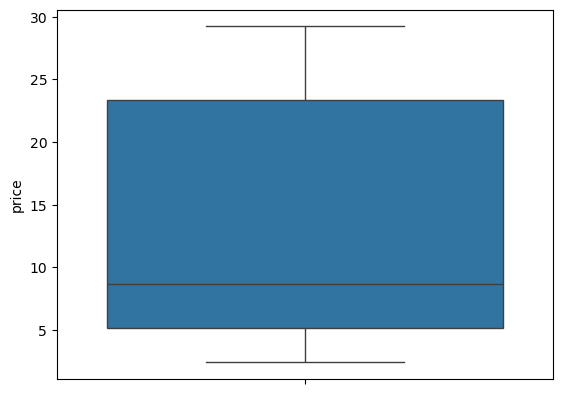

In [33]:
sns.boxplot(df_all['price'])

In [34]:
df_all["day"] = df_all["date"].dt.strftime("%w").astype(int)
df_all["week"] = df_all["date"].dt.isocalendar().week
df_all["month"] = df_all["date"].dt.strftime("%m").astype(int)
df_all["year"] = df_all["date"].dt.strftime("%Y").astype(int)
df_all["quarter"] = (df_all["month"].astype(int) / 4 + 1).round().astype(int)

In [35]:
train = df_all[df_all["date"] <= '2021-06-30']
test = df_all[df_all["date"] > '2021-06-30']
X_train = train.drop('item_count', axis=1)[["date_int", "item_id", "price", "kcal", "store_id"]]
X_test = test.drop('item_count', axis=1)[["date_int", "item_id", "price", "kcal", "store_id"]]
y_train = train["item_count"]
y_test = test["item_count"]

## Linear Regression

In [37]:
model = sfm.ols(formula="item_count ~ date_int + item_id + price + kcal + store_id", data=train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             item_count   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     706.7
Date:                Mon, 22 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:13:45   Log-Likelihood:                -65144.
No. Observations:               16028   AIC:                         1.303e+05
Df Residuals:                   16022   BIC:                         1.303e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -36.6836    303.454     -0.121      0.9

In [38]:
def calculate_residuals(model, features, label):
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual' : label, 'Predicted' : predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    return df_results

def linear_assumptions(model, features, label):
    df_results = calculate_residuals(model, features, label)
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords, color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

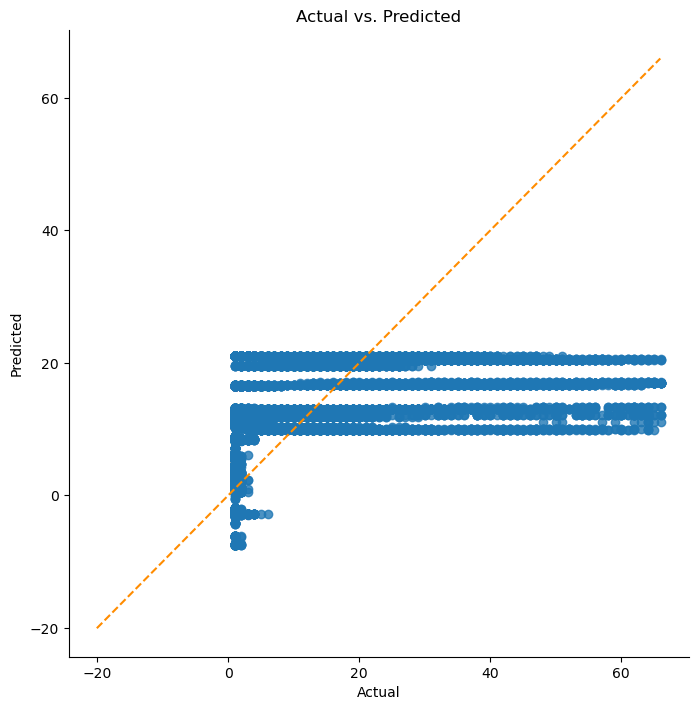

In [39]:
data = X_train
target = y_train
linear_assumptions(model, data, target)

In [40]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,date_int,item_id,price,kcal,store_id
date_int,1.000000,0.005188,-0.039520,-0.010691,-0.006012
item_id,0.005188,1.000000,-0.209976,-0.128256,0.356341
price,-0.039520,-0.209976,1.000000,0.244986,-0.162693
kcal,-0.010691,-0.128256,0.244986,1.000000,-0.287748
store_id,-0.006012,0.356341,-0.162693,-0.287748,1.000000


In [41]:
x = data.astype(float) # Convert the array to float type
vif_data = pd.DataFrame()
vif_data['Features'] = x.columns
vif_data['vif'] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
print(vif_data)

   Features        vif
0  date_int  14.978566
1   item_id   4.003885
2     price   3.479351
3      kcal   8.923229
4  store_id   2.729025


In [42]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
print(X_train.dtype)
print(y_train.dtype)
print(np.isnan(X_train).sum())
print(np.isnan(y_train).sum())
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

float64
float64
0
0
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.111
Model:                            OLS   Adj. R-squared (uncentered):              0.111
Method:                 Least Squares   F-statistic:                              400.9
Date:                Mon, 22 Dec 2025   Prob (F-statistic):                        0.00
Time:                        21:13:46   Log-Likelihood:                         -69686.
No. Observations:               16028   AIC:                                  1.394e+05
Df Residuals:                   16023   BIC:                                  1.394e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [44]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred_test_lr = reg.predict(X_test)

In [45]:
lr_r2 = r2_score(y_test, y_pred_test_lr)
lr_mae = mean_absolute_error(y_test, y_pred_test_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
print("LR - R Square: {}".format(lr_r2))
print("LR - MAE: {}".format(lr_mae))
print("LR - RMSE: {}".format(lr_rmse))

LR - R Square: 0.14602143977302628
LR - MAE: 11.262596645806331
LR - RMSE: 14.97894261815826


In [46]:
results = pd.DataFrame([lr_r2, lr_mae,lr_rmse], index = ['R Square', 'MAE', 'RMSE'], columns = ['Linear Regression']).round(2)
results

,Linear Regression
R Square,0.15
MAE,11.26
RMSE,14.98


## Random Forest

In [47]:
yy_train = y_train.ravel()
regressor = RandomForestRegressor(n_estimators=100, max_depth=20)
regressor.fit(X_train, yy_train)
y_pred_test_rf = regressor.predict(X_test)

In [48]:
rf_r2 = r2_score(y_test, y_pred_test_rf)
rf_mae = mean_absolute_error(y_test, y_pred_test_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
print("RF - R Square: {}".format(rf_r2))
print("RF - MAE: {}".format(rf_mae))
print("RF - RMSE: {}".format(rf_rmse))

RF - R Square: 0.6172222955056681
RF - MAE: 5.194969114583651
RF - RMSE: 10.028384803979561


In [49]:
results['Random Forest'] = [rf_r2,rf_mae,rf_rmse]
results.round(2)

,Linear Regression,Random Forest
R Square,0.15,0.62
MAE,11.26,5.19
RMSE,14.98,10.03


## XGBoost

In [50]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:19.40281	validation_1-rmse:19.73977
[1]	validation_0-rmse:19.27194	validation_1-rmse:19.61678
[2]	validation_0-rmse:19.14280	validation_1-rmse:19.49546
[3]	validation_0-rmse:19.01538	validation_1-rmse:19.37578
[4]	validation_0-rmse:18.88967	validation_1-rmse:19.25774
[5]	validation_0-rmse:18.76563	validation_1-rmse:19.14131
[6]	validation_0-rmse:18.64316	validation_1-rmse:19.01877
[7]	validation_0-rmse:18.52234	validation_1-rmse:18.90537
[8]	validation_0-rmse:18.40304	validation_1-rmse:18.78585
[9]	validation_0-rmse:18.28536	validation_1-rmse:18.67540
[10]	validation_0-rmse:18.16918	validation_1-rmse:18.55883
[11]	validation_0-rmse:18.05458	validation_1-rmse:18.45128
[12]	validation_0-rmse:17.94145	validation_1-rmse:18.33761
[13]	validation_0-rmse:17.83687	validation_1-rmse:18.24250
[14]	validation_0-rmse:17.73378	validation_1-rmse:18.14882
[15]	validation_0-rmse:17.62435	validation_1-rmse:18.03871
[16]	validation_0-rmse:17.52378	validation_1-rmse:17.94746
[17]	va

[139]	validation_0-rmse:10.89395	validation_1-rmse:11.54432
[140]	validation_0-rmse:10.86149	validation_1-rmse:11.51431
[141]	validation_0-rmse:10.83414	validation_1-rmse:11.48300
[142]	validation_0-rmse:10.81256	validation_1-rmse:11.46567
[143]	validation_0-rmse:10.79439	validation_1-rmse:11.44812
[144]	validation_0-rmse:10.76321	validation_1-rmse:11.41947
[145]	validation_0-rmse:10.73252	validation_1-rmse:11.39105
[146]	validation_0-rmse:10.71491	validation_1-rmse:11.37337
[147]	validation_0-rmse:10.69445	validation_1-rmse:11.35702
[148]	validation_0-rmse:10.66461	validation_1-rmse:11.32941
[149]	validation_0-rmse:10.64764	validation_1-rmse:11.31298
[150]	validation_0-rmse:10.61850	validation_1-rmse:11.28618
[151]	validation_0-rmse:10.59400	validation_1-rmse:11.25789
[152]	validation_0-rmse:10.57760	validation_1-rmse:11.24160
[153]	validation_0-rmse:10.55841	validation_1-rmse:11.22634
[154]	validation_0-rmse:10.53031	validation_1-rmse:11.20030
[155]	validation_0-rmse:10.51443	validat

[278]	validation_0-rmse:8.93696	validation_1-rmse:9.57947
[279]	validation_0-rmse:8.93195	validation_1-rmse:9.57576
[280]	validation_0-rmse:8.92095	validation_1-rmse:9.56027
[281]	validation_0-rmse:8.91554	validation_1-rmse:9.55589
[282]	validation_0-rmse:8.90475	validation_1-rmse:9.54072
[283]	validation_0-rmse:8.90023	validation_1-rmse:9.53481
[284]	validation_0-rmse:8.88961	validation_1-rmse:9.52080
[285]	validation_0-rmse:8.88518	validation_1-rmse:9.51770
[286]	validation_0-rmse:8.87512	validation_1-rmse:9.50799
[287]	validation_0-rmse:8.87055	validation_1-rmse:9.50309
[288]	validation_0-rmse:8.86539	validation_1-rmse:9.49899
[289]	validation_0-rmse:8.85513	validation_1-rmse:9.48513
[290]	validation_0-rmse:8.85092	validation_1-rmse:9.48153
[291]	validation_0-rmse:8.84120	validation_1-rmse:9.47214
[292]	validation_0-rmse:8.83685	validation_1-rmse:9.46754
[293]	validation_0-rmse:8.82737	validation_1-rmse:9.45837
[294]	validation_0-rmse:8.82170	validation_1-rmse:9.45045
[295]	validati

[420]	validation_0-rmse:8.25208	validation_1-rmse:8.81238
[421]	validation_0-rmse:8.25010	validation_1-rmse:8.81152
[422]	validation_0-rmse:8.24717	validation_1-rmse:8.81172
[423]	validation_0-rmse:8.24522	validation_1-rmse:8.81082
[424]	validation_0-rmse:8.24078	validation_1-rmse:8.80556
[425]	validation_0-rmse:8.23724	validation_1-rmse:8.80151
[426]	validation_0-rmse:8.23284	validation_1-rmse:8.79346
[427]	validation_0-rmse:8.23092	validation_1-rmse:8.79240
[428]	validation_0-rmse:8.22661	validation_1-rmse:8.78505
[429]	validation_0-rmse:8.22313	validation_1-rmse:8.78104
[430]	validation_0-rmse:8.21663	validation_1-rmse:8.77140
[431]	validation_0-rmse:8.21239	validation_1-rmse:8.76664
[432]	validation_0-rmse:8.21049	validation_1-rmse:8.76543
[433]	validation_0-rmse:8.20633	validation_1-rmse:8.75786
[434]	validation_0-rmse:8.20447	validation_1-rmse:8.75638
[435]	validation_0-rmse:8.19808	validation_1-rmse:8.74695
[436]	validation_0-rmse:8.19400	validation_1-rmse:8.74220
[437]	validati

[562]	validation_0-rmse:7.82213	validation_1-rmse:8.36986
[563]	validation_0-rmse:7.81589	validation_1-rmse:8.36766
[564]	validation_0-rmse:7.81162	validation_1-rmse:8.35452
[565]	validation_0-rmse:7.80951	validation_1-rmse:8.35238
[566]	validation_0-rmse:7.80815	validation_1-rmse:8.35167
[567]	validation_0-rmse:7.80398	validation_1-rmse:8.33907
[568]	validation_0-rmse:7.79867	validation_1-rmse:8.33114
[569]	validation_0-rmse:7.79457	validation_1-rmse:8.31901
[570]	validation_0-rmse:7.79302	validation_1-rmse:8.31915
[571]	validation_0-rmse:7.79145	validation_1-rmse:8.31794
[572]	validation_0-rmse:7.79019	validation_1-rmse:8.31764
[573]	validation_0-rmse:7.78411	validation_1-rmse:8.31552
[574]	validation_0-rmse:7.78009	validation_1-rmse:8.30391
[575]	validation_0-rmse:7.77844	validation_1-rmse:8.30405
[576]	validation_0-rmse:7.77418	validation_1-rmse:8.29790
[577]	validation_0-rmse:7.77026	validation_1-rmse:8.28695
[578]	validation_0-rmse:7.76773	validation_1-rmse:8.28295
[579]	validati

[704]	validation_0-rmse:7.49078	validation_1-rmse:8.03550
[705]	validation_0-rmse:7.48928	validation_1-rmse:8.03585
[706]	validation_0-rmse:7.48674	validation_1-rmse:8.03473
[707]	validation_0-rmse:7.48555	validation_1-rmse:8.03493
[708]	validation_0-rmse:7.48118	validation_1-rmse:8.02768
[709]	validation_0-rmse:7.47894	validation_1-rmse:8.02714
[710]	validation_0-rmse:7.47790	validation_1-rmse:8.02735
[711]	validation_0-rmse:7.47717	validation_1-rmse:8.02720
[712]	validation_0-rmse:7.47569	validation_1-rmse:8.02756
[713]	validation_0-rmse:7.47455	validation_1-rmse:8.02780
[714]	validation_0-rmse:7.47207	validation_1-rmse:8.02697
[715]	validation_0-rmse:7.47063	validation_1-rmse:8.02733
[716]	validation_0-rmse:7.46950	validation_1-rmse:8.02757
[717]	validation_0-rmse:7.46670	validation_1-rmse:8.02666
[718]	validation_0-rmse:7.46525	validation_1-rmse:8.02551
[719]	validation_0-rmse:7.46426	validation_1-rmse:8.02492
[720]	validation_0-rmse:7.46211	validation_1-rmse:8.02465
[721]	validati

[846]	validation_0-rmse:7.27084	validation_1-rmse:8.00352
[847]	validation_0-rmse:7.26895	validation_1-rmse:8.00597
[848]	validation_0-rmse:7.26819	validation_1-rmse:8.00567
[849]	validation_0-rmse:7.26761	validation_1-rmse:8.00639
[850]	validation_0-rmse:7.26709	validation_1-rmse:8.00593
[851]	validation_0-rmse:7.26611	validation_1-rmse:8.00633
[852]	validation_0-rmse:7.26440	validation_1-rmse:8.00977
[853]	validation_0-rmse:7.26356	validation_1-rmse:8.01003
[854]	validation_0-rmse:7.26270	validation_1-rmse:8.01033
[855]	validation_0-rmse:7.25899	validation_1-rmse:8.00477
[856]	validation_0-rmse:7.25714	validation_1-rmse:8.00739
[857]	validation_0-rmse:7.25663	validation_1-rmse:8.00897
[858]	validation_0-rmse:7.25570	validation_1-rmse:8.00923
[859]	validation_0-rmse:7.25514	validation_1-rmse:8.00998
[860]	validation_0-rmse:7.25419	validation_1-rmse:8.01036


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
y_pred_test_xgb = model.predict(X_test)

In [52]:
xgb_r2 = r2_score(y_test, y_pred_test_xgb)
xgb_mae = mean_absolute_error(y_test, y_pred_test_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
print("XGB - R Square: {}".format(xgb_r2))
print("XGB - MAE: {}".format(xgb_mae))
print("XGB - RMSE: {}".format(xgb_rmse))

XGB - R Square: 0.7564037670168626
XGB - MAE: 5.257088244589435
XGB - RMSE: 8.00005471530409


In [53]:
results['XG Boost'] = [xgb_r2,xgb_mae,xgb_rmse]
results.round(2)

,Linear Regression,Random Forest,XG Boost
R Square,0.15,0.62,0.76
MAE,11.26,5.19,5.26
RMSE,14.98,10.03,8.00


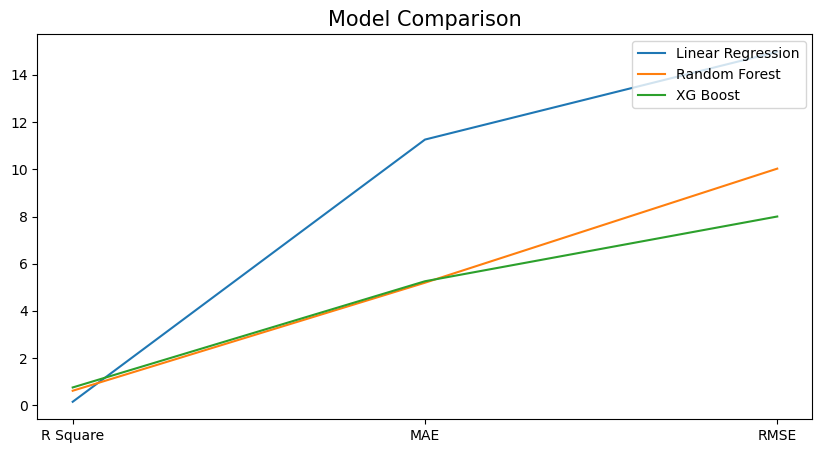

In [54]:
plt.figure(figsize = (10,5))
plt.plot(results['Linear Regression'], label = "Linear Regression")
plt.plot(results['Random Forest'], label = "Random Forest")
plt.plot(results['XG Boost'], label = "XG Boost")
plt.legend(loc = "upper right")
plt.title("Model Comparison", size = 15)
plt.show()

## Forecast

### We use Random Forest to forecast data for 2024

In [63]:
forecast_year = 2024
all_items = df_items.drop('name', axis=1).rename({"id": "item_id"}, axis=1)
daterange = pd.date_range(f"{forecast_year}-01-01", f"{forecast_year}-12-31")
forecast_year_date_ints = daterange.map(lambda dt: int(dt.strftime('%Y%m%d')))
X_forecast = pd.DataFrame()
n_items = all_items.shape[0]
for dt in forecast_year_date_ints:
    dts = pd.DataFrame({"date_int": np.full(n_items, dt)})
    items = pd.concat((dts, all_items), axis=1)
    X_forecast = pd.concat((X_forecast, items), axis=0)

In [64]:
sc = StandardScaler()
X_forecast_scaled = sc.fit_transform(X_forecast)
y_forecast = regressor.predict(np.asarray(X_forecast_scaled))
X_forecast = X_forecast.merge(df_restaurants, right_on="id", left_on="store_id", left_index=False, right_index=False)
X_forecast = X_forecast.rename({"name":"store_name"}, axis=1).reset_index()
X_forecast["item_count"] = y_forecast
X_forecast["date"] = X_forecast["date_int"].astype("str")
X_forecast["month"] = X_forecast["date"].str[4:6]
X_forecast

,index,date_int,item_id,store_id,kcal,cost,id,store_name,item_count,date,month
0,0,20240101,1,4,554,6.71,4,Fou Cher,10.670000,20240101,01
1,1,20240101,2,4,772,15.09,4,Fou Cher,1.030000,20240101,01
2,2,20240101,3,1,931,29.22,1,Bob's Diner,1.000000,20240101,01
3,3,20240101,4,1,763,26.42,1,Bob's Diner,1.000000,20240101,01
4,4,20240101,5,5,583,6.07,5,Corner Cafe,10.140000,20240101,01
...,...,...,...,...,...,...,...,...,...,...,...
36595,36595,20241231,96,5,708,21.93,5,Corner Cafe,1.000000,20241231,12
36596,36596,20241231,97,4,744,28.65,4,Fou Cher,1.000000,20241231,12
36597,36597,20241231,98,2,579,5.00,2,Beachfront Bar,17.049309,20241231,12
36598,36598,20241231,99,4,423,5.32,4,Fou Cher,59.310000,20241231,12


In [65]:
df_forecast_store_sales_by_month = X_forecast[["store_name", "month", "item_count"]].groupby(by=["store_name", "month"]).sum().reset_index()

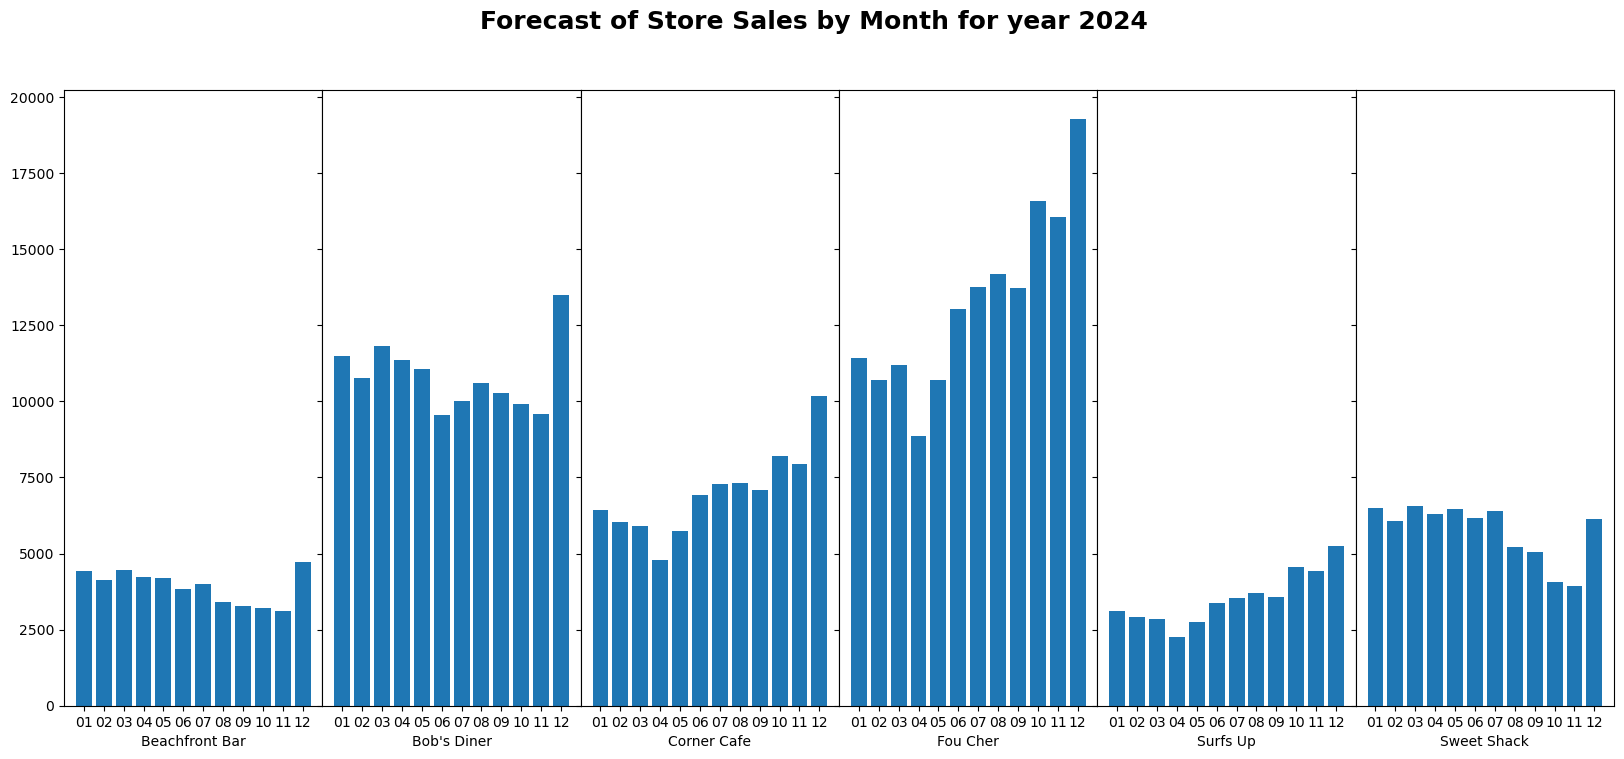

In [66]:
store_names = df_forecast_store_sales_by_month["store_name"].unique()
fig, axs = plt.subplots(1, len(store_names), sharey=True, figsize=(20,8))
for ax, store_name in zip(axs, store_names):
    df = df_forecast_store_sales_by_month[df_forecast_store_sales_by_month["store_name"] == store_name]
    ax.bar(df["month"], df["item_count"])
    ax.set_xlabel(store_name)
fig.subplots_adjust(wspace=0)
plt.suptitle(f"Forecast of Store Sales by Month for year {forecast_year}", fontsize=18, fontweight="bold")
plt.show()